In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as  np
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
X_train = pd.read_csv("X_train_Wwou3IE.csv")
y_train = pd.read_csv("y_train_jJtXgMX.csv")
X_test_final = pd.read_csv("X_test_GgyECq8.csv")

In [3]:
display(X_train.head())
print(X_train.shape)

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN


(10605, 10)


In [4]:
display(y_train.head())
print(y_train.shape)

,DELIVERY_START,spot_id_delta
0,2022-01-01 02:00:00+01:00,-36.874770
1,2022-01-01 03:00:00+01:00,-12.643588
2,2022-01-01 04:00:00+01:00,-1.950193
3,2022-01-01 05:00:00+01:00,1.938272
4,2022-01-01 06:00:00+01:00,0.199907


(10605, 2)


In [5]:
X_train.isnull().sum()

DELIVERY_START                      0
load_forecast                    1287
coal_power_available                1
gas_power_available                 1
nucelear_power_available            1
wind_power_forecasts_average       24
solar_power_forecasts_average      24
wind_power_forecasts_std           24
solar_power_forecasts_std          24
predicted_spot_price             8759
dtype: int64

In [6]:
X_test_final.isnull().sum()

DELIVERY_START                      0
load_forecast                       0
coal_power_available                0
gas_power_available                 0
nucelear_power_available            0
wind_power_forecasts_average        0
solar_power_forecasts_average      24
wind_power_forecasts_std            0
solar_power_forecasts_std          24
predicted_spot_price             1536
dtype: int64

In [7]:
X_test_final.shape

(4942, 10)

### Observation 1:

* From the observation of missing values, we can see that we have the predicted spot price for a lot of rows on our X_test 
* Which means that at some point it would be usefull to create models that take this feature into acccount 
* Even though in our training set this feature is missing most of the times 

In [8]:
print(X_train.dtypes,"\n \n",y_train.dtypes)

DELIVERY_START                    object
load_forecast                    float64
coal_power_available             float64
gas_power_available              float64
nucelear_power_available         float64
wind_power_forecasts_average     float64
solar_power_forecasts_average    float64
wind_power_forecasts_std         float64
solar_power_forecasts_std        float64
predicted_spot_price             float64
dtype: object 
 
 DELIVERY_START     object
spot_id_delta     float64
dtype: object


In [9]:
# Here I will just explore at what date we have missing values for load_forcast and predicted_spot_price 
# But first we need to process the datetime DELIVERY_START

In [10]:
def date_process(df):
    # Split 'DELIVERY_START' column into 'datetime' and 'unknown'
    df[['datetime', 'unknown']] = df['DELIVERY_START'].str.split('+', expand=True)

    # Convert 'datetime' column to datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])


    # Insert 'datetime' and 'unknown' columns after 'DELIVERY_START'
    df.insert(loc=df.columns.get_loc('DELIVERY_START') + 1, column='datetime', value=df.pop('datetime'))
    df.insert(loc=df.columns.get_loc('DELIVERY_START') + 2, column='unknown', value=df.pop('unknown'))

    df.drop(columns=['DELIVERY_START'], inplace=True)

    if len(df["datetime"].unique())== len(df):
        df.set_index("datetime", inplace = True)

    return df

date_process(y_train)
y_train = y_train.drop(columns='unknown')
date_process(X_train).head(2)

,unknown,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
datetime,,,,,,,,,,
2022-01-01 02:00:00,01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN
2022-01-01 03:00:00,01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN


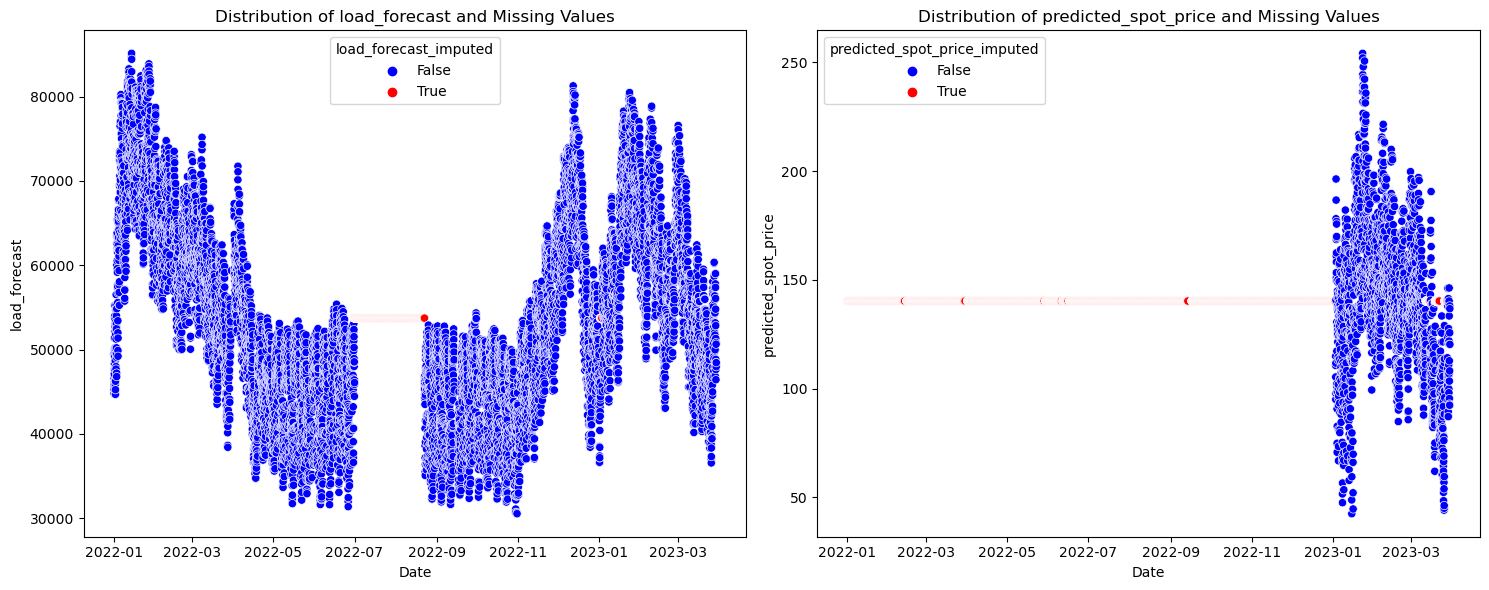

In [11]:
X_train_filled = X_train[["load_forecast","predicted_spot_price"]].copy()
mean_values = X_train_filled.mean()
X_train_filled = X_train_filled.fillna(mean_values)

for column in X_train_filled.columns:
    X_train_filled[f'{column}_imputed'] = X_train[column].isna()
    
# Create a figure with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for column1
sns.scatterplot(ax=axes[0], data=X_train_filled, x=X_train_filled.index, y=X_train_filled.columns[0], hue=f'{X_train_filled.columns[0]}_imputed', palette={True: 'red', False: 'blue'})
axes[0].set_title(f'Distribution of {X_train_filled.columns[0]} and Missing Values')
axes[0].set_xlabel('Date')
axes[0].set_ylabel(X_train_filled.columns[0])

# Plot for column2
sns.scatterplot(ax=axes[1], data=X_train_filled, x=X_train_filled.index, y=X_train_filled.columns[1], hue=f'{X_train_filled.columns[1]}_imputed', palette={True: 'red', False: 'blue'})
axes[1].set_title(f'Distribution of {X_train_filled.columns[1]} and Missing Values')
axes[1].set_xlabel('Date')
axes[1].set_ylabel(X_train_filled.columns[1])

# Adjust layout
plt.tight_layout()
plt.show()

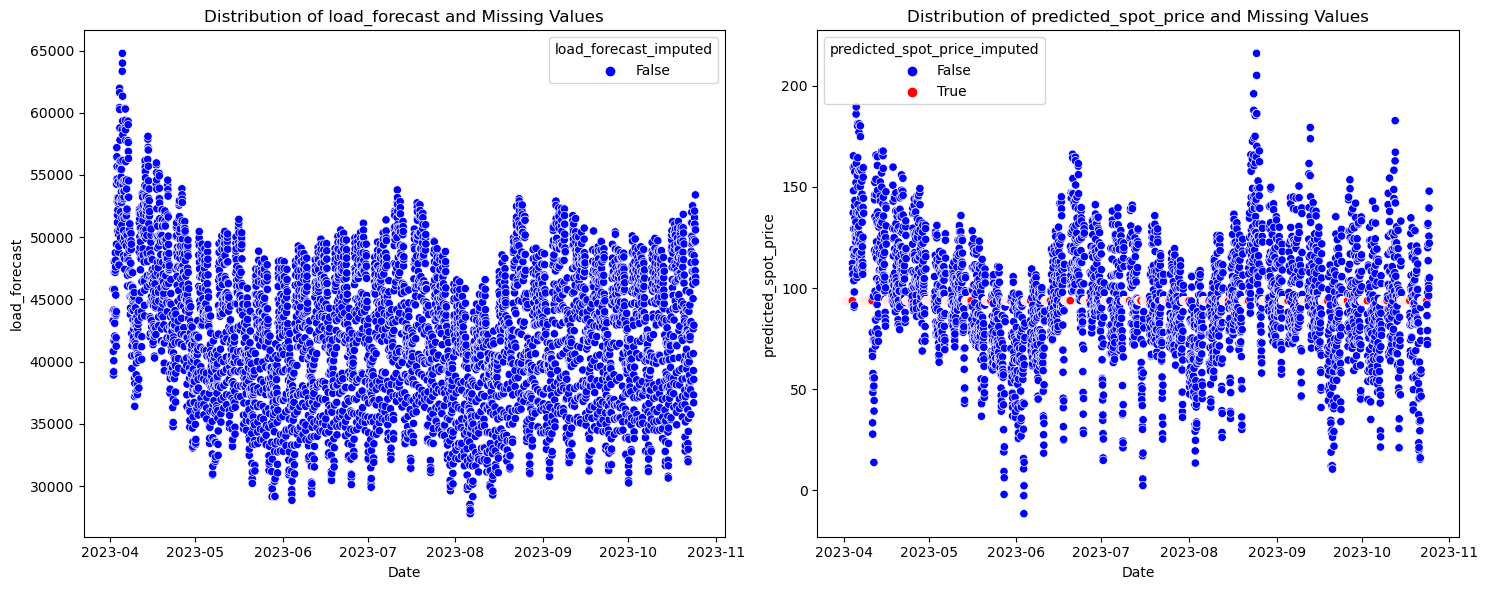

In [12]:
date_process(X_test_final)

X_test_filled = X_test_final[["load_forecast","predicted_spot_price"]].copy()
mean_values = X_test_filled.mean()
X_test_filled = X_test_filled.fillna(mean_values)

for column in X_test_filled.columns:
    X_test_filled[f'{column}_imputed'] = X_test_final[column].isna()
    
# Create a figure with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for column1
sns.scatterplot(ax=axes[0], data=X_test_filled, x=X_test_filled.index, y=X_test_filled.columns[0], hue=f'{X_test_filled.columns[0]}_imputed', palette={True: 'red', False: 'blue'})
axes[0].set_title(f'Distribution of {X_test_filled.columns[0]} and Missing Values')
axes[0].set_xlabel('Date')
axes[0].set_ylabel(X_test_filled.columns[0])

# Plot for column2
sns.scatterplot(ax=axes[1], data=X_test_filled, x=X_test_filled.index, y=X_test_filled.columns[1], hue=f'{X_test_filled.columns[1]}_imputed', palette={True: 'red', False: 'blue'})
axes[1].set_title(f'Distribution of {X_test_filled.columns[1]} and Missing Values')
axes[1].set_xlabel('Date')
axes[1].set_ylabel(X_test_filled.columns[1])

# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
# Maybe forward fill is better for handling the missing values of predicted spot price
# Also Here we can see that for the challenge we want to predict the delta from April to November 
# So we need to take into account the periodicity of the season

## 1. Exploration of data

### 1.1 Mutual Information:

In [14]:
def X_train_1(df,version=1):
    if version == 1:
        # Whithout any missing values for each rows
        X_train1 = df.dropna()
        
    elif version == 2:
        X_train1 = df.drop("predicted_spot_price",axis =1)
        X_train1 = X_train1.dropna()

    elif version == 3:
        X_train1 = df.drop(columns = ["load_forecast","predicted_spot_price"])
        X_train1 = X_train1.dropna()

    # Whithout the "unknown" column
    try:
        X_train1 = X_train1.drop("unknown",axis= 1)
    except:
        pass

    return X_train1

X_train1 = X_train_1(X_train,1)
X_train1.head(2)

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
datetime,,,,,,,,,
2023-01-03 01:00:00,48275.0,3386.0,11945.0,42390.0,3792.0,0.0,64.529291,0.0,114.88
2023-01-03 02:00:00,47626.0,3386.0,11945.0,42390.0,4033.0,0.0,87.206239,0.0,110.62


In [15]:
from sklearn.feature_selection import mutual_info_regression

# For now I don't know what is the + inside DELIVERY_START so I will just ignore it for y_train
y_train1 = y_train.loc[X_train1.index,["spot_id_delta"]]
y_train1 = y_train1.iloc[:,0]

# Calculate mutual information
mi_scores = mutual_info_regression(X_train1, y_train1)

# Create a dataframe to display the mutual information scores
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train1.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Display the top n features
n = 10  # Change this value as needed
top_n_features = mi_scores.head(n)
print("Top {} Features by Mutual Information:".format(n))
print(top_n_features)

Top 10 Features by Mutual Information:
nucelear_power_available         0.143853
load_forecast                    0.073533
wind_power_forecasts_average     0.070321
coal_power_available             0.066038
wind_power_forecasts_std         0.064770
predicted_spot_price             0.060373
solar_power_forecasts_average    0.023593
gas_power_available              0.023517
solar_power_forecasts_std        0.006612
Name: MI Scores, dtype: float64


### 1.2 Correlation

In [16]:
# Calculate Pearson correlation coefficients
full_data = pd.concat([X_train1, y_train1], axis=1)
correlation_matrix = full_data.corr()
correlations = correlation_matrix.iloc[:-1, -1]

# Sort correlations in descending order
correlations = correlations.abs().sort_values(ascending=False)

# Display the top n features by correlation
print("\nTop {} Features by Correlation with Target:".format(n))
print(correlations.head(n))


Top 10 Features by Correlation with Target:
nucelear_power_available         0.162307
predicted_spot_price             0.158885
load_forecast                    0.151067
wind_power_forecasts_average     0.141031
coal_power_available             0.084439
wind_power_forecasts_std         0.058272
gas_power_available              0.046505
solar_power_forecasts_std        0.038249
solar_power_forecasts_average    0.000804
Name: spot_id_delta, dtype: float64


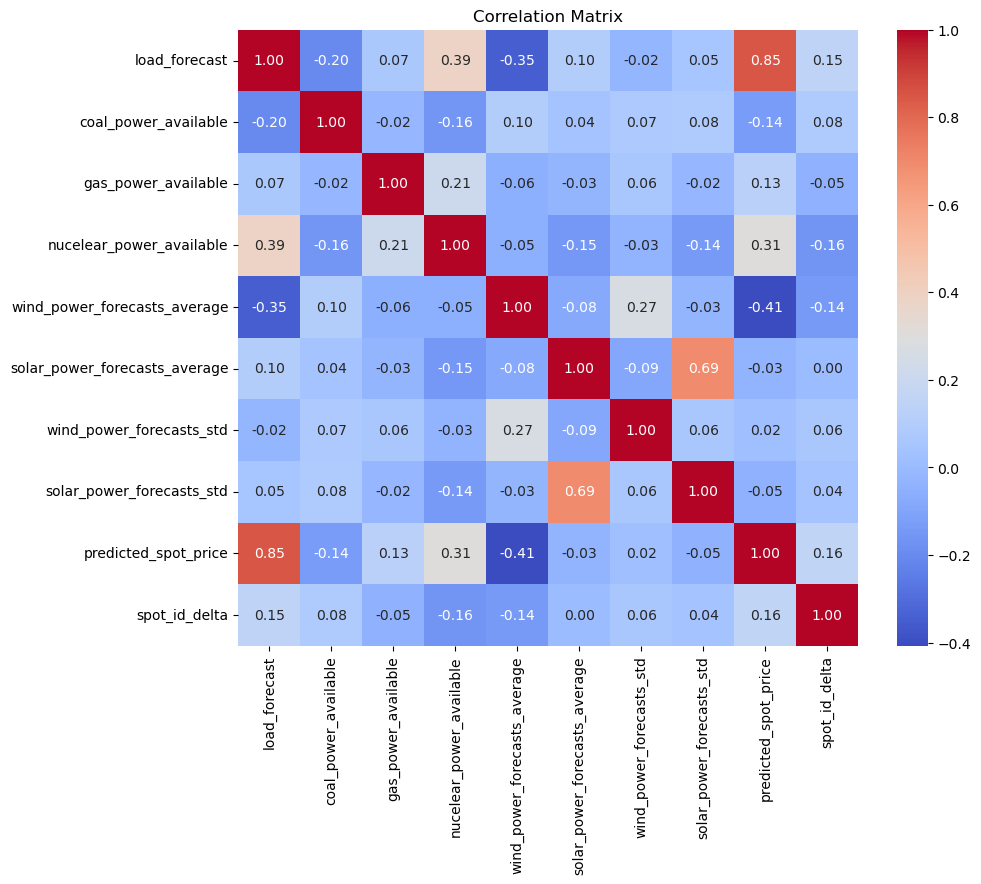

In [17]:
# Plot correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

In [18]:
y_train.describe()

,spot_id_delta
count,10605.000000
mean,0.943358
std,38.093819
min,-1567.353547
25%,-11.934152
50%,0.059125
75%,12.190489
max,658.961329


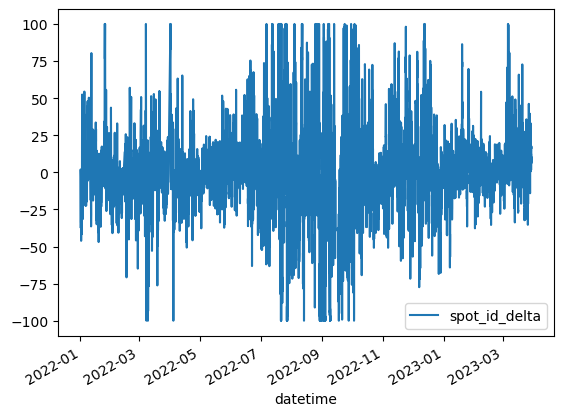

In [139]:
y_train.clip(lower=-100, upper=100).plot()
plt.show()

$\color{blue}{\text{1. REMARK : There is huge outliers, which will impact the linear regression, maybe we will have to remove it for the fitting of models that are impacted by outliers}}$


## 2. Feature Engineering

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Here I will just create a class to create new features, the usual one with lag,mean,max,min,rolling etc...
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create a copy of X to avoid modifying the original dataframe
        X = X.copy()
        X = X.fillna(X.mean())

        initial_features = list(X.columns) + ["TOTAL1","TOTAL2","TOTAL3","TOTAL4"]

        # Intuitive new column
        X["TOTAL1"] = X["coal_power_available"] + X["gas_power_available"] + X['nucelear_power_available']
        X["TOTAL2"] = X["coal_power_available"] + X["gas_power_available"] + X['nucelear_power_available'] + X['wind_power_forecasts_average'] + X['solar_power_forecasts_average']
        X["TOTAL3"] = X["TOTAL1"] - X['load_forecast']
        X["TOTAL4"] = X["TOTAL2"] - X['load_forecast']
 
        # Lagged values
        for feature in initial_features:
            X[f'{feature}_lag1'] = X[feature].shift(1)
            X[f'{feature}_lag2'] = X[feature].shift(2)
        
        # Difference from lagged values
        for feature in initial_features:
            X[f'{feature}_diff1'] = X[feature] - X[f'{feature}_lag1']
            X[f'{feature}_diff2'] = X[feature] - X[f'{feature}_lag2']
        
        # Rolling statistics (using 3-day window)
        rolling_funcs = {
            'mean': lambda x: x.rolling(window=3).mean(),
            'std': lambda x: x.rolling(window=3).std(),
            'min': lambda x: x.rolling(window=3).min(),
            'max': lambda x: x.rolling(window=3).max(),
            'median': lambda x: x.rolling(window=3).median()
        }
        
        for feature in initial_features:
            for stat_name, func in rolling_funcs.items():
                X[f'{feature}_{stat_name}_rolling3'] = func(X[feature])
        
        # Interaction features
        interaction_pairs = [
            ('load_forecast', 'nucelear_power_available'),
            ('wind_power_forecasts_average', 'solar_power_forecasts_average')
        ]
        
        for feature1, feature2 in interaction_pairs:
            X[f'{feature1}_{feature2}_interaction'] = X[feature1] * X[feature2]
            X[f'{feature1}_{feature2}_ratio'] = X[feature1] / (X[feature2] + 1)  # Avoid division by zero
        
        # Transformation features
        transformation_features = ['predicted_spot_price', 'load_forecast']
        
        for feature in transformation_features:
            X[f'{feature}_log'] = np.log1p(X[feature])  # Logarithm transformation
            X[f'{feature}_sqrt'] = np.sqrt(X[feature])  # Square root transformation
        
        # Drop any rows with NaN values resulting from lagged or rolling calculations
        X = X.fillna(X.mean())
        
        return X
    

# Define the pipeline with only the feature engineering transformer
pipeline = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer())
])

# Fit and transform the training data
X_train_transformed = pipeline.fit_transform(X_train.drop("unknown", axis = 1).fillna(X_train.mean()))

In [21]:
y_train1 = y_train.loc[X_train_transformed.index,["spot_id_delta"]]
y_train1 = y_train1.iloc[:,0]

# Calculate mutual information
mi_scores = mutual_info_regression(X_train_transformed, y_train1)

# Create a dataframe to display the mutual information scores
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train_transformed.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Display the top n features
n = 10  # Change this value as needed
top_n_features = mi_scores.head(n)
print("Top {} Features by Mutual Information:".format(n))
print(top_n_features)

Top 10 Features by Mutual Information:
TOTAL1_min_rolling3                         0.155076
TOTAL1_lag1                                 0.152554
TOTAL1_median_rolling3                      0.148986
TOTAL1                                      0.148084
TOTAL1_lag2                                 0.147828
TOTAL1_max_rolling3                         0.146563
nucelear_power_available_max_rolling3       0.144054
TOTAL1_mean_rolling3                        0.143534
nucelear_power_available                    0.139760
nucelear_power_available_median_rolling3    0.136142
Name: MI Scores, dtype: float64


## 3. Cross Validation !

In [22]:
# TO DO: It's good to have a good idea of the performance of the model to train it and test it on different part of the dataset
# This will give us a better idea of the performance of our model
# And Ideally we also want a validation set that will give us a final idea of the performance of our data
# Ideally the validation set will be representative of the whole data, with equivalent distribution

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [24]:
def k_fold_cv(model, X, y, n_splits=5):
    """
    Perform k-fold cross-validation.

    Parameters:
    - model: A scikit-learn model instance
    - X: Feature matrix
    - y: Target vector
    - n_splits: Number of splits for cross-validation

    Returns:
    - mean_error: Mean of RMSE across all folds
    """
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    errors = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        errors.append(rmse)
    
    mean_error = np.mean(errors)

    # Predict on the entire dataset
    y_full_pred = model.predict(X)
    
    # Plot predictions vs. targets
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_full_pred, alpha=0.6, edgecolors="w", linewidth=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predictions vs Actual Values")
    plt.grid(True)
    plt.show()
    
    return mean_error

### 3.1 NEW_FILL 

In [25]:
# The IDEA LOAD FORECAST and PREDICTED SPOT PRICE are highly correlated. 
# Since this concerns energy, there is likely periodicity due to weather seasons. 
# Therefore, you can use Prophet to predict LOAD FORECAST for the missing values and 
# then use LOAD FORECAST as an explanatory variable for PREDICTED SPOT PRICE.
# This approach will yield better results than simply filling in missing values with the mean.

,ds,y
0,2022-01-01 02:00:00,49439.0
1,2022-01-01 03:00:00,46511.0
2,2022-01-01 04:00:00,45158.0
3,2022-01-01 05:00:00,44779.0
4,2022-01-01 06:00:00,45284.0
...,...,...
10600,2023-03-29 19:00:00,50814.0
10601,2023-03-29 20:00:00,50628.0
10602,2023-03-29 21:00:00,48201.0
10603,2023-03-29 22:00:00,47967.0


14:22:20 - cmdstanpy - INFO - Chain [1] start processing
14:22:24 - cmdstanpy - INFO - Chain [1] done processing


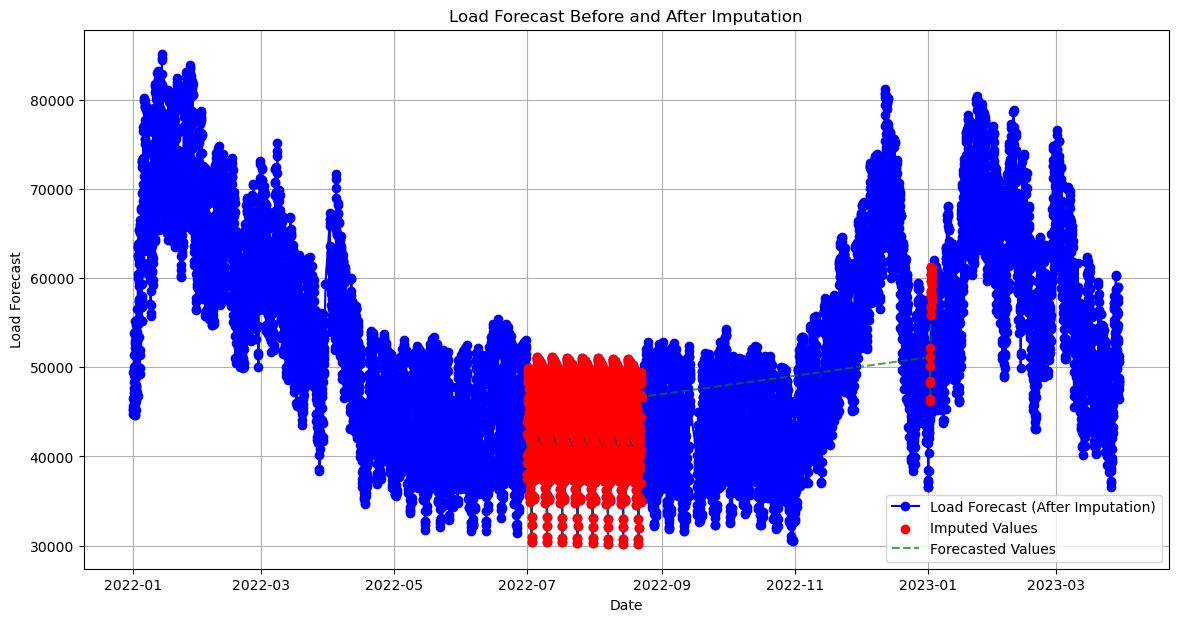

In [27]:
from prophet import Prophet

X_train_prophet = X_train[["load_forecast"]]

# Reset the index to make 'date' a column
df_prophet = X_train_prophet.reset_index()
df_prophet.rename(columns={'datetime': 'ds', 'load_forecast': 'y'}, inplace=True)

display(df_prophet)

# Initialize Prophet model
model = Prophet()

# Fit the model using only non-missing values
model.fit(df_prophet.dropna(subset=['y']))

# Create a DataFrame with the missing dates
missing_dates = df_prophet[df_prophet['y'].isna()]['ds']
future_df = pd.DataFrame({'ds': missing_dates})

# Predict missing values
forecast = model.predict(future_df)

# Update the original DataFrame with predicted values
X_train_prophet.loc[X_train_prophet['load_forecast'].isna(), 'load_forecast'] = forecast['yhat'].values

# Plotting
plt.figure(figsize=(14, 7))

# Plot original data
plt.plot(X_train_prophet.index, X_train_prophet['load_forecast'], label='Load Forecast (After Imputation)', color='blue', linestyle='-', marker='o')

# Plot the imputed points
imputed_dates = df_prophet[df_prophet['y'].isna()]['ds']
imputed_values = forecast['yhat']
plt.scatter(imputed_dates, imputed_values, color='red', label='Imputed Values', zorder=5)

# Plot the predicted values by Prophet
plt.plot(forecast['ds'], forecast['yhat'], linestyle='--', color='green', label='Forecasted Values', alpha=0.7)

# Add titles and labels
plt.title('Load Forecast Before and After Imputation')
plt.xlabel('Date')
plt.ylabel('Load Forecast')
plt.legend()
plt.grid(True)
plt.show()

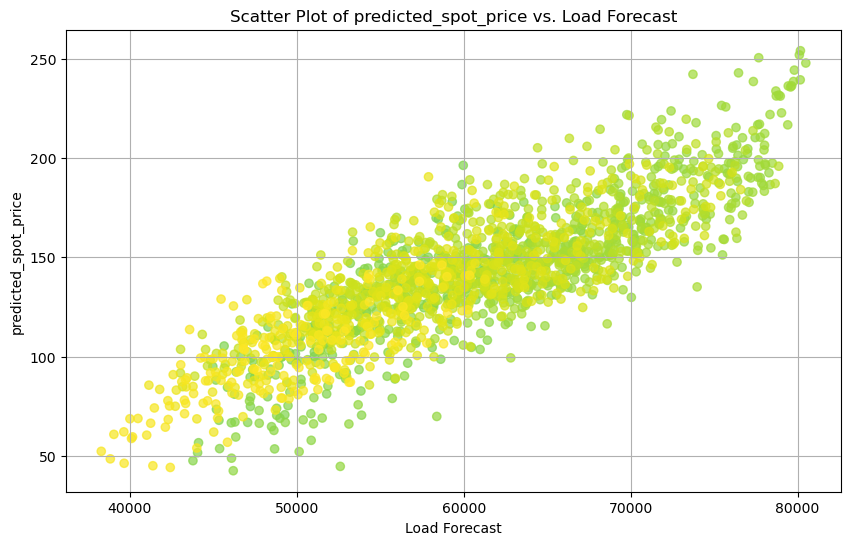

In [28]:
# Scatter plot
plt.figure(figsize=(10, 6))

# Use the row number for coloring
row_numbers = np.arange(len(X_train))
norm = plt.Normalize(row_numbers.min(), row_numbers.max())
cmap = plt.get_cmap('viridis')  # You can choose different colormaps

# Map row numbers to colors
colors = cmap(norm(row_numbers))

# Plot 'load_forecast' vs. 'AA'
plt.scatter(X_train['load_forecast'], X_train['predicted_spot_price'] , alpha=0.7, c = colors, marker='o')

# Add titles and labels
plt.title('Scatter Plot of predicted_spot_price vs. Load Forecast')
plt.xlabel('Load Forecast')
plt.ylabel('predicted_spot_price')
plt.grid(True)
plt.show()

In [30]:
from sklearn.linear_model import LinearRegression

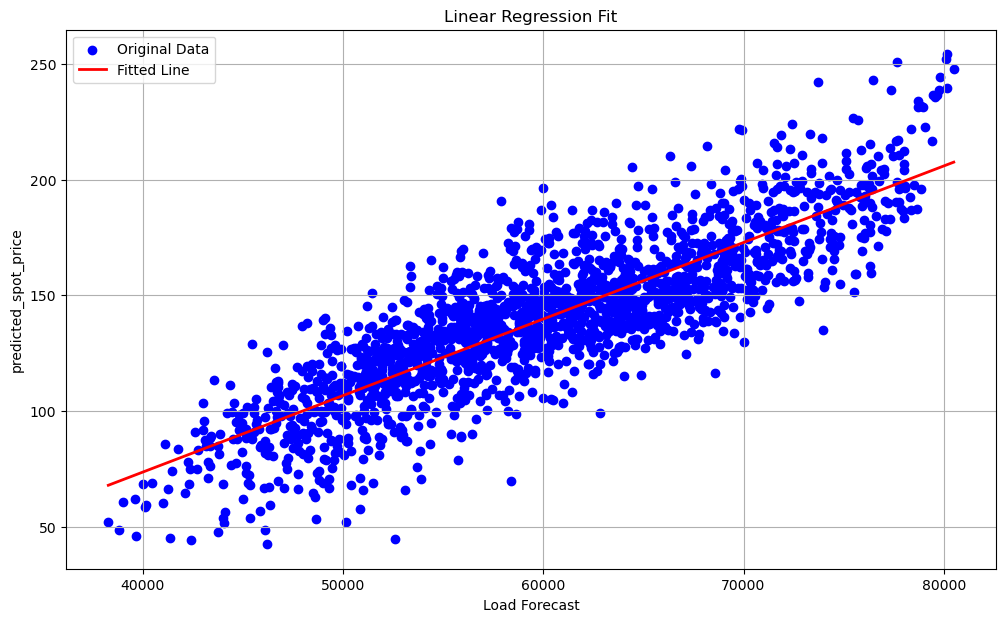

In [31]:
X_good_fill = X_train[['load_forecast','predicted_spot_price']].dropna()
model = LinearRegression()
X_values = X_good_fill[['load_forecast']]
Y_values = X_good_fill['predicted_spot_price']
model.fit(X_values,Y_values)

# Predict values using the linear model for plotting
x_vals = np.linspace(X_good_fill['load_forecast'].min(), X_good_fill['load_forecast'].max(), 100).reshape(-1, 1)
y_vals = model.predict(x_vals)

# Create the scatter plot and regression line plot
plt.figure(figsize=(12, 7))

# Plot original data points
plt.scatter(X_train['load_forecast'], X_train['predicted_spot_price'], color='blue', label='Original Data')

# Plot the regression line
plt.plot(x_vals, y_vals, color='red', label='Fitted Line', linewidth=2)

# Add titles and labels
plt.title('Linear Regression Fit')
plt.xlabel('Load Forecast')
plt.ylabel('predicted_spot_price')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
x_vals.shape

(100, 1)

In [33]:
# Now we will replace the missing values of predicted_spot_price by this linear regression
X_good_fill2 = model.predict(X_train_prophet[['load_forecast']])
X_train["load_forecast2"] = X_train_prophet['load_forecast']
X_train["predicted_spot_price2"] = X_good_fill2

In [34]:
X_train["predicted_spot_price3"] = X_train["predicted_spot_price"].fillna(X_train["predicted_spot_price2"])
X_train.to_csv('X_train_new_fill.csv')

## 4. Model Selection

In [35]:
X_train = pd.read_csv("X_train_new_fill.csv")

In [36]:
# NOW we have a new way of filling values
X_train['load_forecast'] = X_train['load_forecast2']
X_train['predicted_spot_price'] = X_train['predicted_spot_price3']
X_train = X_train.iloc[:,:-3]

X_train = X_train.set_index('datetime',drop='True')
X_train

,unknown,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
datetime,,,,,,,,,,
2022-01-01 02:00:00,01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,104.796378
2022-01-01 03:00:00,01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,95.108660
2022-01-01 04:00:00,01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,90.632061
2022-01-01 05:00:00,01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,89.378084
2022-01-01 06:00:00,01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,91.048951
...,...,...,...,...,...,...,...,...,...,...
2023-03-29 19:00:00,02:00,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,108.110000
2023-03-29 20:00:00,02:00,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,125.660000
2023-03-29 21:00:00,02:00,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,138.010000


In [37]:
# Fit and transform the training data
X_train_transformed2 = pipeline.fit_transform(X_train.drop("unknown", axis = 1).fillna(X_train.mean()))

In [38]:
X_train_transformed2.head(2)

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,TOTAL1,...,TOTAL4_max_rolling3,TOTAL4_median_rolling3,load_forecast_nucelear_power_available_interaction,load_forecast_nucelear_power_available_ratio,wind_power_forecasts_average_solar_power_forecasts_average_interaction,wind_power_forecasts_average_solar_power_forecasts_average_ratio,predicted_spot_price_log,predicted_spot_price_sqrt,load_forecast_log,load_forecast_sqrt
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 02:00:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,104.796378,58991.0,...,5171.355303,3604.636195,2.181150e+09,1.120583,0.0,3035.0,4.661516,10.237010,10.808515,222.348825
2022-01-01 03:00:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,95.108660,58991.0,...,5171.355303,3604.636195,2.051972e+09,1.054217,0.0,3143.0,4.565479,9.752367,10.747466,215.664091


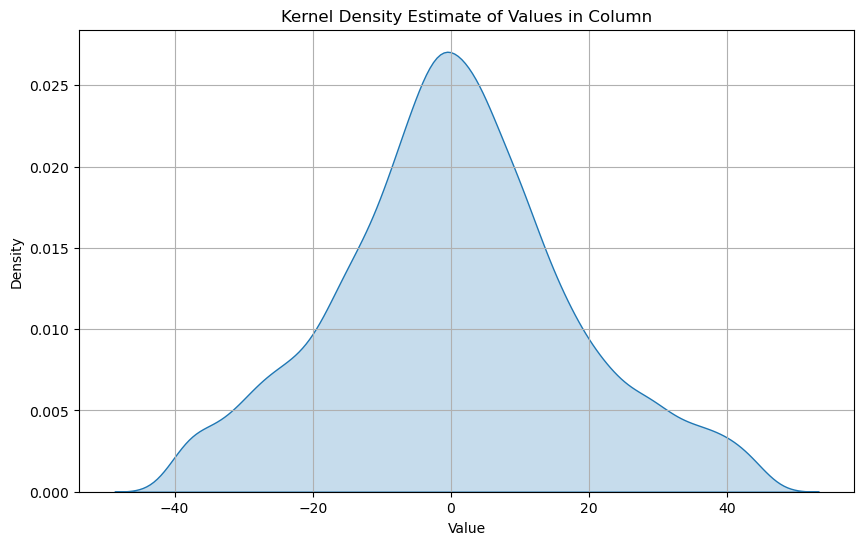

In [94]:
# Before we fit the linear model, we can drop the outliers for y_train
# Plot kernel density estimate (KDE) of 'values' column
plt.figure(figsize=(10, 6))
sns.kdeplot(y_train.loc[~y_train.index.isin(outliers_index)]['spot_id_delta'], shade=True)
plt.title('Kernel Density Estimate of Values in Column')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [93]:
# Calculate 5th and 95th percentiles
percentile_5 = y_train['spot_id_delta'].quantile(0.05)
percentile_95 = y_train['spot_id_delta'].quantile(0.95)

# Find indices where values are above the 95th percentile or below the 5th percentile
outliers_index = y_train[(y_train['spot_id_delta'] > percentile_95) | 
                         (y_train['spot_id_delta'] < percentile_5)].index


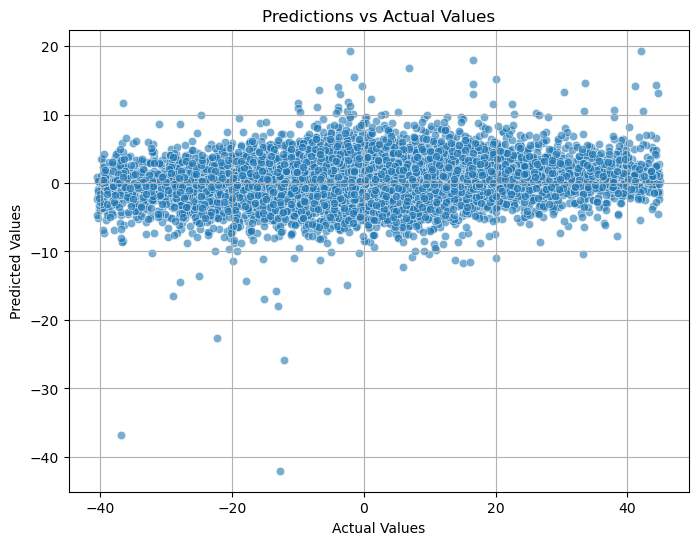

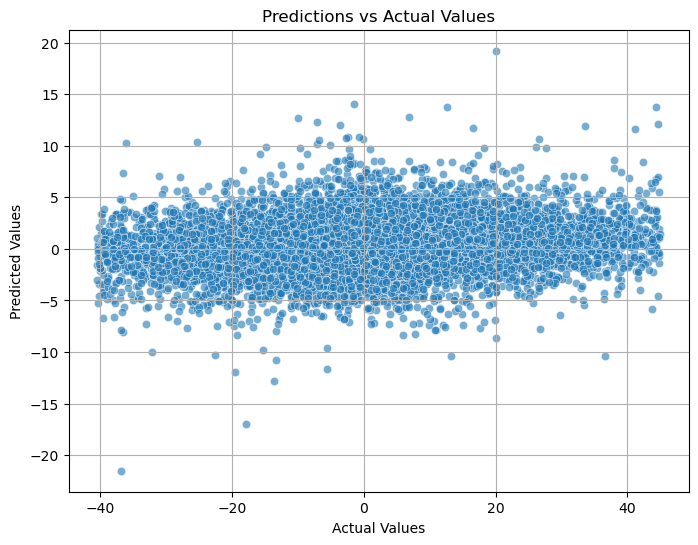

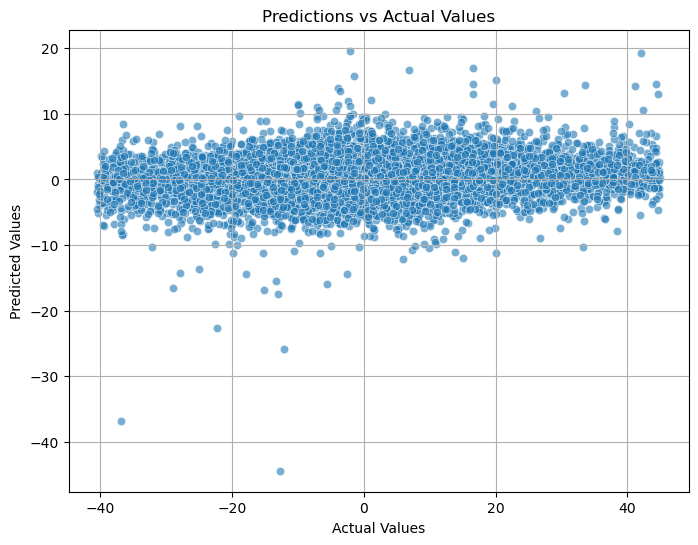

LinearRegression - Mean RMSE: 17.008443647080252
Lasso (alpha=0.1) - Mean RMSE: 16.982903159863557
Ridge (alpha=0.1) - Mean RMSE: 17.005536243501798


In [41]:
# The first model that I like to build is the most simple one just to give us an idea -->> LINEAR REGRESSION

from sklearn.linear_model import LinearRegression, Lasso, Ridge

# Define models with fixed hyperparameters
models = {
    'LinearRegression': LinearRegression(),
    'Lasso (alpha=0.1)': Lasso(alpha=0.1),
    'Ridge (alpha=0.1)': Ridge(alpha=0.1)
}

# Evaluate models
results = {}
for model_name, model in models.items():
    mean_error = k_fold_cv(model, X_train_transformed.drop(outliers_index), y_train.drop(outliers_index), n_splits=5)
    results[model_name] = mean_error

# Print results
for model_name, mean_error in results.items():
    print(f"{model_name} - Mean RMSE: {mean_error}")

In [42]:
import joblib

class ModelEvaluator:
    def __init__(self, X, y, n_splits=5):
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.models = {}
        self.results = {}
        self._fit_cache = {}
        self._model_instances = {}

    def k_fold_cv(self, model_name, model):
        """
        Perform k-fold cross-validation and cache the result.

        Parameters:
        - model_name: Name of the model for identification
        - model: A scikit-learn model instance

        Returns:
        - mean_error: Mean of RMSE across all folds
        """
        if model_name in self._fit_cache:
            return self._fit_cache[model_name]
        
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        errors = []

        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            
            # Fit the model
            model.fit(X_train, y_train)
            
            # Predict and evaluate
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            errors.append(rmse)
        
        mean_error = np.mean(errors)
        self._fit_cache[model_name] = mean_error
        self._model_instances[model_name] = model
        return mean_error

    def add_model(self, model_name, model):
        """
        Add a model to the evaluator.

        Parameters:
        - model_name: Name of the model
        - model: A scikit-learn model instance
        """
        self.models[model_name] = model

    def evaluate_models(self):
        """
        Evaluate all added models and store results.
        """
        for model_name, model in self.models.items():
            mean_error = self.k_fold_cv(model_name, model)
            self.results[model_name] = mean_error

    def print_results(self):
        """
        Print the results of the model evaluations.
        """
        for model_name, mean_error in self.results.items():
            print(f"{model_name} - Mean RMSE: {mean_error}")

    def get_model(self, model_name):
        """
        Retrieve the fitted model instance.

        Parameters:
        - model_name: Name of the model

        Returns:
        - model: The fitted model instance or None if not found
        """
        return self._model_instances.get(model_name, None)

    def save_model(self, model_name, filename):
        """
        Save the fitted model to a file.

        Parameters:
        - model_name: Name of the model
        - filename: Path to the file where the model will be saved
        """
        model = self.get_model(model_name)
        if model:
            joblib.dump(model, filename)
            print(f"Model '{model_name}' saved to {filename}")
        else:
            print(f"Model '{model_name}' not found.")

    def load_model(self, model_name, filename):
        """
        Load a model from a file and update the model cache.

        Parameters:
        - model_name: Name of the model
        - filename: Path to the file from which the model will be loaded
        """
        model = joblib.load(filename)
        self._model_instances[model_name] = model
        print(f"Model '{model_name}' loaded from {filename}")


# Create the ModelEvaluator instance
evaluator = ModelEvaluator(X_train_transformed, y_train, n_splits=5)

# Define and add models
evaluator.add_model('LinearRegression', LinearRegression())
evaluator.add_model('Lasso (alpha=0.1)', Lasso(alpha=0.1))
evaluator.add_model('Ridge (alpha=0.1)', Ridge(alpha=0.1))

# Evaluate models
evaluator.evaluate_models()

# Print results
evaluator.print_results()

LinearRegression - Mean RMSE: 37.438223774802594
Lasso (alpha=0.1) - Mean RMSE: 37.31082692445278
Ridge (alpha=0.1) - Mean RMSE: 37.44072677238326


In [43]:

# If I want to save the model in a file, otherwise I will still have access through the instance evaluator
# # Save and load models
evaluator.save_model('RF (n_estimators=300, max_depth=25, min_samples_split=10, min_samples_leaf=5)', 'RF_300.pkl')
# evaluator.load_model('LinearRegression', 'linear_regression_model.pkl')

# # Use the loaded model for prediction
# loaded_model = evaluator.get_model('LinearRegression')

Model 'RF (n_estimators=300, max_depth=25, min_samples_split=10, min_samples_leaf=5)' not found.


## 6. Model Testing

In [44]:
# 1 -- Now I want to try different model when I use the data where I use a different version for filling the missing values 
# and also remove the outliers
# 2 -- I will also try to fit a model using only the data where I don't have any missing values
# 3 -- I also want to try when I just make it a classification problem, maybe do a combination of both

In [45]:
# 1 --
evaluator2 = ModelEvaluator(X_train_transformed2, y_train, n_splits=5)

In [47]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

evaluator2.add_model('xgb',xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3))
evaluator2.add_model('xgb2',xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=3))
evaluator2.add_model('xgb5',xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1, max_depth=3))
evaluator2.add_model('RF (n_estimators=300, max_depth=25, min_samples_split=10, min_samples_leaf=10)', RandomForestRegressor(n_estimators=300, max_depth=25, min_samples_split=10, min_samples_leaf=10))

evaluator2.evaluate_models()

evaluator2.print_results()

xgb - Mean RMSE: 34.11577243529172
xgb2 - Mean RMSE: 33.11742563500984
xgb5 - Mean RMSE: 31.814634125410485
RF (n_estimators=300, max_depth=25, min_samples_split=10, min_samples_leaf=10) - Mean RMSE: 32.807003256763934


In [48]:
X_train2 = pd.read_csv("X_train_Wwou3IE.csv")
Index_no_missing = X_train2.dropna().index
print(Index_no_missing)
X_train_transformed2.iloc[Index_no_missing].head(2)

Int64Index([ 8567,  8568,  8569,  8570,  8571,  8572,  8573,  8574,  8575,
             8576,
            ...
            10595, 10596, 10597, 10598, 10599, 10600, 10601, 10602, 10603,
            10604],
           dtype='int64', length=1822)


,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,TOTAL1,...,TOTAL4_max_rolling3,TOTAL4_median_rolling3,load_forecast_nucelear_power_available_interaction,load_forecast_nucelear_power_available_ratio,wind_power_forecasts_average_solar_power_forecasts_average_interaction,wind_power_forecasts_average_solar_power_forecasts_average_ratio,predicted_spot_price_log,predicted_spot_price_sqrt,load_forecast_log,load_forecast_sqrt
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-03 01:00:00,48275.0,3386.0,11945.0,42390.0,3792.0,0.0,64.529291,0.0,114.88,57721.0,...,13238.0,11382.0,2.046377e+09,1.138803,0.0,3792.0,4.752555,10.718209,10.784690,219.715725
2023-01-03 02:00:00,47626.0,3386.0,11945.0,42390.0,4033.0,0.0,87.206239,0.0,110.62,57721.0,...,14128.0,13238.0,2.018866e+09,1.123493,0.0,4033.0,4.715100,10.517604,10.771155,218.233820


In [49]:
# 2 --
evaluator3 = ModelEvaluator(X_train_transformed2.iloc[Index_no_missing], y_train.iloc[Index_no_missing], n_splits=5)

In [50]:
models = { 'RF (n_estimators=300, max_depth=25, min_samples_split=10, min_samples_leaf=10)': RandomForestRegressor(n_estimators=300, max_depth=25, min_samples_split=10, min_samples_leaf=10) }

# Add models to the evaluator
for model_name, model in models.items():
    evaluator3.add_model(model_name, model)

# Evaluate models
evaluator3.evaluate_models()

evaluator3.print_results()

RF (n_estimators=300, max_depth=25, min_samples_split=10, min_samples_leaf=10) - Mean RMSE: 12.755176547774209


In [98]:
y_train
y_train2 = y_train['spot_id_delta'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

datetime
2022-01-01 02:00:00   -1
2022-01-01 03:00:00   -1
2022-01-01 04:00:00   -1
2022-01-01 05:00:00    1
2022-01-01 06:00:00    1
                      ..
2023-03-29 19:00:00    1
2023-03-29 20:00:00    1
2023-03-29 21:00:00    1
2023-03-29 22:00:00    1
2023-03-29 23:00:00    1
Name: spot_id_delta, Length: 10605, dtype: int64

In [99]:
# 3 --
evaluator4 = ModelEvaluator(X_train_transformed2, y_train2, n_splits=5)

In [221]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Example dictionary of models with their hyperparameters
models = {
    'Random Forest (n_estimators=300, max_depth=25)': RandomForestClassifier(n_estimators=300, max_depth=25),
    'Gradient Boosting (n_estimators=300, learning_rate=0.1)': GradientBoostingClassifier(n_estimators=300, learning_rate=0.1),
    'AdaBoost (n_estimators=100)': AdaBoostClassifier(n_estimators=100),
    'SVM (C=1.0, kernel="rbf")': SVC(C=1.0, kernel='rbf', probability=True),
    'K-Neighbors (n_neighbors=5)': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression (C=1.0)': LogisticRegression(C=1.0, max_iter=1000),
    'Decision Tree (max_depth=10)': DecisionTreeClassifier(max_depth=10),
    'Lasso (alpha=100)': Lasso(alpha=100) 
}

# Assuming evaluator3 is your evaluator instance
for model_name, model in models.items():
    evaluator4.add_model(model_name, model)

# Evaluate models
evaluator4.evaluate_models()

# Print the results
evaluator4.print_results()

Random Forest (n_estimators=300, max_depth=25) - Mean RMSE: 0.9915384294913412
Gradient Boosting (n_estimators=300, learning_rate=0.1) - Mean RMSE: 1.1647139160081335
AdaBoost (n_estimators=100) - Mean RMSE: 1.278082639670624
SVM (C=1.0, kernel="rbf") - Mean RMSE: 1.3944958014522937
K-Neighbors (n_neighbors=5) - Mean RMSE: 1.4118631521140632
Logistic Regression (C=1.0) - Mean RMSE: 1.4119427186387643
Decision Tree (max_depth=10) - Mean RMSE: 1.2427167635122631
Lasso (alpha=0.1) - Mean RMSE: 0.9973753484659807
Lasso (alpha=0.5) - Mean RMSE: 0.9972121205856588
Lasso (alpha=1) - Mean RMSE: 0.9970420532886688
Lasso (alpha=10) - Mean RMSE: 0.9977299330358915
Lasso (alpha=100) - Mean RMSE: 0.9985254249798989


In [231]:
evaluator5 = ModelEvaluator(X_train_transformed2[non_zero_features], y_train2, n_splits=5)

In [232]:
# Example dictionary of models with their hyperparameters
models = {
    'Random Forest (n_estimators=300, max_depth=25)': RandomForestClassifier(n_estimators=300, max_depth=25),
    'Gradient Boosting (n_estimators=300, learning_rate=0.1)': GradientBoostingClassifier(n_estimators=300, learning_rate=0.1),
    'AdaBoost (n_estimators=100)': AdaBoostClassifier(n_estimators=100),
    'SVM (C=1.0, kernel="rbf")': SVC(C=1.0, kernel='rbf', probability=True),
    'K-Neighbors (n_neighbors=5)': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression (C=1.0)': LogisticRegression(C=1.0, max_iter=1000),
    'Decision Tree (max_depth=10)': DecisionTreeClassifier(max_depth=10),
    'Lasso (alpha=100)': Lasso(alpha=100) 
}

# Assuming evaluator3 is your evaluator instance
for model_name, model in models.items():
    evaluator5.add_model(model_name, model)

# Evaluate models
evaluator5.evaluate_models()

# Print the results
evaluator5.print_results()

Random Forest (n_estimators=300, max_depth=25) - Mean RMSE: 1.1063571139764066
Gradient Boosting (n_estimators=300, learning_rate=0.1) - Mean RMSE: 1.1812419973955386
AdaBoost (n_estimators=100) - Mean RMSE: 1.2893511975220773
SVM (C=1.0, kernel="rbf") - Mean RMSE: 1.3931369035201377
K-Neighbors (n_neighbors=5) - Mean RMSE: 1.4119978458587543
Logistic Regression (C=1.0) - Mean RMSE: 1.4118081542829217
Decision Tree (max_depth=10) - Mean RMSE: 1.28770117764847
Lasso (alpha=100) - Mean RMSE: 0.9984911509589895


In [51]:

models = { 'RF (n_estimators=300, max_depth=25, min_samples_split=10, min_samples_leaf=10)': RandomForestRegressor(n_estimators=300, max_depth=25, min_samples_split=10, min_samples_leaf=10) }

# Add models to the evaluator
for model_name, model in models.items():
    evaluator.add_model(model_name, model)

# Evaluate models
evaluator.evaluate_models()


In [52]:
def new_print(self):
    """
    Print the results of the model evaluations, showing only the top 5 performing models.
    """
    # Sort the results by mean RMSE in ascending order (lowest RMSE first)
    sorted_results = sorted(self.results.items(), key=lambda item: item[1])
    
    # Print only the top 5 performing models
    top_n = min(10, len(sorted_results))  # Handle cases where there are fewer than 5 models
    print(f"Top {top_n} Performing Models:")
    for model_name, mean_error in sorted_results[:top_n]:
        print(f"{model_name} - Mean RMSE: {mean_error:.4f}")

In [53]:
evaluator.print_results = new_print.__get__(evaluator)

In [54]:
# Print results
evaluator.print_results()

Top 4 Performing Models:
RF (n_estimators=300, max_depth=25, min_samples_split=10, min_samples_leaf=10) - Mean RMSE: 32.0755
Lasso (alpha=0.1) - Mean RMSE: 37.3108
LinearRegression - Mean RMSE: 37.4382
Ridge (alpha=0.1) - Mean RMSE: 37.4407


## 7. DATA CLEANING

In [55]:
# Here we are going to check if we can improve the linear model -->
# 1. Remove Outliers for the fitting
# 2. Don't fill NA by the mean 
# 3. It would be also cool to create new features, that seem sensible to me

In [56]:
# In the end it would be cool to have clean code, a grid search CV, 
# with good cross validation that allow us to test different models in an efficient manner

# 8. SUBMISSION 

In [57]:
X_test_final = pd.read_csv("X_test_GgyECq8.csv")
indices = X_test_final["DELIVERY_START"]
date_process(X_test_final)
X_test_final = X_test_final.drop(columns="unknown")

In [58]:
X_test_transformed = pipeline.transform(X_test_final.fillna(X_test_final.mean()))

In [233]:
best_model = sorted(evaluator5.results.items(), key=lambda item: item[1])[0][0]
best_model = evaluator5.models[f"{best_model}"]

In [236]:
predictions = best_model.predict(X_test_transformed[non_zero_features])

# Create the DataFrame for results
results_df = pd.DataFrame({
    'spot_id_delta': predictions,
    'Is_Positive': predictions > 0
}, index=indices)

# Display the result
results_df.head(12)

,spot_id_delta,Is_Positive
DELIVERY_START,,
2023-04-02 00:00:00+02:00,-0.081865,False
2023-04-02 01:00:00+02:00,-0.078636,False
2023-04-02 02:00:00+02:00,-0.050276,False
2023-04-02 03:00:00+02:00,-0.065883,False
2023-04-02 04:00:00+02:00,-0.074764,False
2023-04-02 05:00:00+02:00,-0.086406,False
2023-04-02 06:00:00+02:00,-0.093985,False
2023-04-02 07:00:00+02:00,-0.096515,False
2023-04-02 08:00:00+02:00,-0.095271,False


In [228]:
# Get feature names used in the model
feature_names_in = best_model.feature_names_in_

# Identify features with non-zero coefficients
non_zero_features = [feature_names_in[i] for i in range(len(best_model.coef_)) if best_model.coef_[i] != 0]

# Print the features with non-zero coefficients
print("Features with non-zero coefficients:")
print(non_zero_features)

Features with non-zero coefficients:
['load_forecast', 'load_forecast_lag2', 'nucelear_power_available_lag2', 'solar_power_forecasts_average_lag2', 'load_forecast_diff1', 'solar_power_forecasts_average_diff2', 'TOTAL3_diff1', 'load_forecast_min_rolling3', 'load_forecast_max_rolling3', 'gas_power_available_max_rolling3', 'nucelear_power_available_min_rolling3', 'solar_power_forecasts_average_min_rolling3', 'TOTAL4_max_rolling3', 'load_forecast_nucelear_power_available_interaction', 'wind_power_forecasts_average_solar_power_forecasts_average_interaction', 'wind_power_forecasts_average_solar_power_forecasts_average_ratio']


In [204]:
# Define the function to apply the transformation
def transform_prediction(value):
    if -0.1 < value < 0:
        return 1
    return value

# Apply the function to the 'Prediction' column
results_df['spot_id_delta1'] = results_df['spot_id_delta'].apply(transform_prediction)
results_df['Is_Positive1'] = results_df['spot_id_delta1'] > 0

In [237]:
results_df.sum()

spot_id_delta   -357.060606
Is_Positive      141.000000
dtype: float64

In [206]:
results_df2 = results_df[["spot_id_delta1"]]
results_df2 = results_df2.rename(columns={"spot_id_delta1":"spot_id_delta"})
results_df2

,spot_id_delta
DELIVERY_START,
2023-04-02 00:00:00+02:00,0.155815
2023-04-02 01:00:00+02:00,0.095755
2023-04-02 02:00:00+02:00,0.129170
2023-04-02 03:00:00+02:00,0.063773
2023-04-02 04:00:00+02:00,0.091428
...,...
2023-10-24 19:00:00+02:00,1.000000
2023-10-24 20:00:00+02:00,1.000000
2023-10-24 21:00:00+02:00,-0.141987


In [207]:
results_df2.to_csv("Toy_model1.csv")

## ANNEXE 

In [142]:
y_train_clip = y_train.clip(lower=-10, upper=10)

In [180]:
# X_train.drop(columns='unknown', inplace = True)
X_train.dropna(inplace= True)

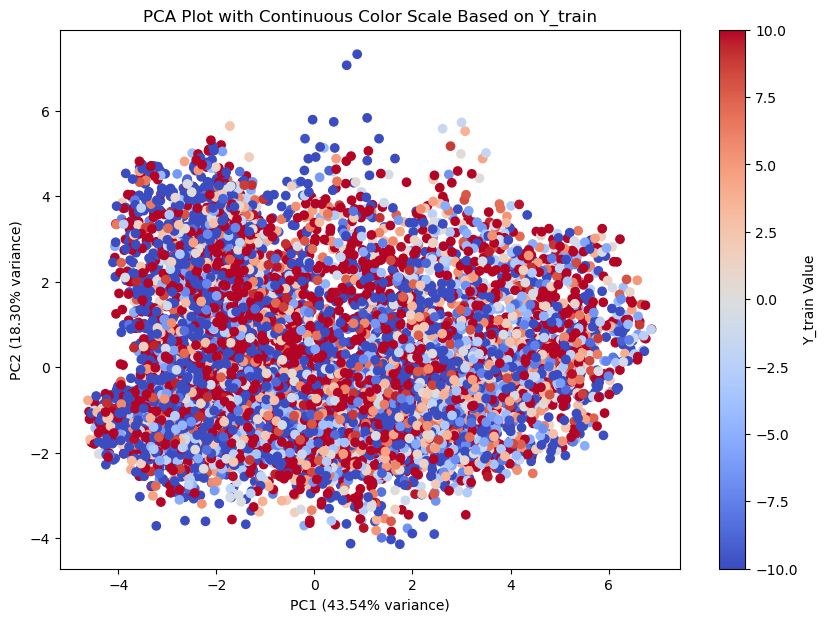

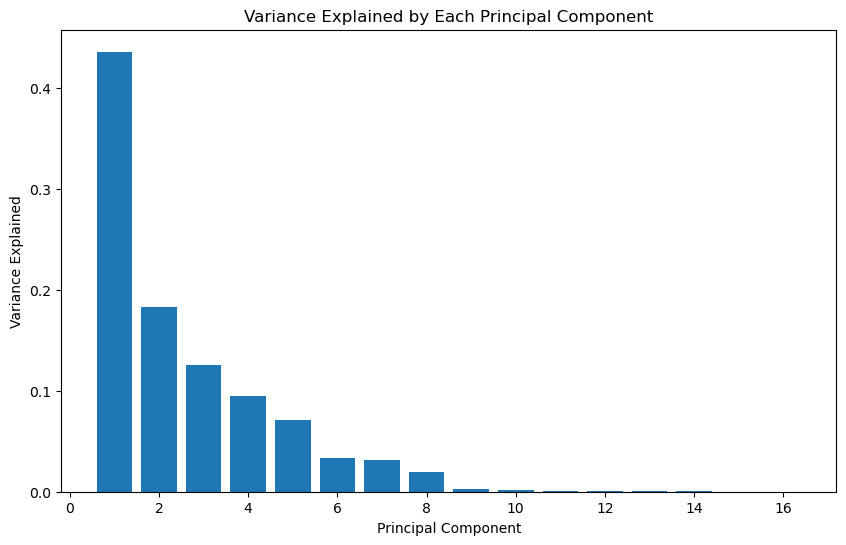

ValueError: Shape of passed values is (16, 16), indices imply (138, 16)

In [230]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns



# Assume X_train_transformed is your DataFrame and Y_train is your continuous labels
# Step 1: Standardize the data
scaler = StandardScaler()
X_pca = X_train_transformed2[non_zero_features].sample(len(X_train))
X_scaled = scaler.fit_transform(X_pca)

# Step 2: Apply PCA
pca = PCA()
pca_fit = pca.fit(X_scaled)

# Step 3: Plot the PCA with a continuous color scale based on Y_train
pca_data = pca_fit.transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
pca_df['Y_train'] = y_train_clip.loc[X_pca.index].values  # Add Y_train as a column

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Y_train'], cmap='coolwarm')
plt.colorbar(scatter, label='Y_train Value')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.title('PCA Plot with Continuous Color Scale Based on Y_train')
plt.show()

# Step 4: Plot variance explained by each component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Principal Component')
plt.show()

# Step 5: Show the PCA loadings (components)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))], index=X_train_transformed.columns)
print("PCA Loadings:\n", loadings)